In [1]:
import pandas as pd
import openai
import json
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for the progress bar


/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_16873/3411647144.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from openai import OpenAI

In [3]:
openai.__version__


'1.12.0'

### Read in data

In [5]:
# Initialize an empty list to store the parsed data
data_list = []

# Read the JSONL file line by line
with open('../data/prodigy/annotated_output/remaining_1300_pubmed_abstracts_shirin.jsonl', 'r') as file:
    for line in file:
        # Parse each line as a JSON object
        data = json.loads(line.strip())
        
        # Check if _view_id is "choice"// should be review if this was coming from a review prodigy session
        if data.get("_view_id") == "choice":
            # Split text into journal_name, title, and abstract based on ^\n symbol
            text = data.get("text", "")
            
            # Splitting text based on ^\n for journal_name, title, and abstract
            parts = text.split("^\n", 2)  # Split into three parts based on first two ^\n occurrences
            
            journal_name = parts[0].strip() if len(parts) > 0 else ""
            title = parts[1].strip() if len(parts) > 1 else ""
            abstract = parts[2].strip() if len(parts) > 2 else ""
            
            # Extract other required fields
            pmid = data.get("pmid", "")
            accept = data.get("accept", [])
            
            # Append to the list
            data_list.append({
                "pmid": pmid,
                "journal_name": journal_name,
                "title": title,
                "abstract": abstract,
                "accepted_label": accept
            })

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data_list)

In [42]:
df.head(5)

,pmid,journal_name,title,abstract,accepted_label
0,18379746,Der Radiologe,[Pediatric stroke].,Stroke in childhood has gained increasingly mo...,[Non-systematic-review]
1,24660674,Journal of consulting and clinical psychology,Treatment engagement and response to CBT among...,"In the current study, we compared measures of ...",[Human-RCT-non-drug-intervention]
2,20159133,Archives of physical medicine and rehabilitation,Relationship between perceived exertion and ph...,To investigate the strength of the relationshi...,[Remaining]
3,11781147,Biochimica et biophysica acta,Characterization of a missense mutation at his...,Genetic defects in pyruvate dehydrogenase comp...,[Remaining]
4,31706919,Epilepsy & behavior : E&B,The role of P-glycoprotein (P-gp) and inwardly...,Sudden unexpected death in epilepsy (SUDEP) is...,[Non-systematic-review]


### Load key for the OpenAI API 

In [7]:
def load_pass(file_path, key_to_find):
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split("=")
            if len(parts) == 2 and parts[0] == key_to_find:
                found_password = parts[1]
                break
    if found_password:
        print("Found password.")
        return found_password
    else:
        print("Password not found for key:", key_to_find)

Note: You need to create a credentials.txt file with the following content:  
OPENAI=sk-77QXXXXXXXXXXXXXXXXXXXXXXXXXXX  
replace the value after the = sign with your API key.  
Make sure the credentials.txt is added to .gitignore, you don't want to put your password on Git!

In [8]:
openai.api_key = load_pass("../credentials.txt", "OPENAI")


Found password.


In [9]:
client = OpenAI(api_key=openai.api_key)

### Query GPT models

To change the task the model is solving, you need to change the text of the prompt and the content text of the system role.  
To change the GPT model used, you need to change the text of the model name when initiating the openai API.  
The function gets as input the input_raw_text, that will be text for information extraction or classification.

In [43]:
import time

def query_gpt(input_raw_text, task, prompt_text, max_retries=5, retry_delay=2):
    """
    Queries GPT model with the provided input text for a specified task.
    
    Parameters:
    - input_raw_text (str): The text to process.
    - task (str): The type of task to perform, e.g., "classify".
    - prompt_text (str): The prompt to use in addition to the input text.
    - max_retries (int): Maximum number of retries if API call fails.
    - retry_delay (int): Seconds to wait before retrying the API call.
    
    Returns:
    - str: The result from the GPT model, or an error message if the task is unknown or retries are exceeded.
    """
    
    # Add a delay at the beginning of the function to avoid overloading the API if there are multiple calls
    time.sleep(20)  # Corrected to 20 seconds as per the comment
    
    if task == "classify":
        prompt = prompt_text
    else:
        return "Task not known."
    
    retries = 0
    while retries < max_retries:
        print("Trying to call OpenAI API...")
        try:
            completion = client.chat.completions.create(
                model="gpt-3.5-turbo",  # CHANGE this to the desired model name, see https://platform.openai.com/docs/models
                temperature=0.6,
                max_tokens=2000,
                messages=[
                    {"role": "system", "content": "You are an expert information extraction assistant from clinical trials."},
                    {"role": "user", "content": prompt + input_raw_text}
                ]
            )
            return completion.choices[0].message.content
        except Exception as e:
            # Handle API error, e.g., retry or log
            print(f"OpenAI API returned an error: {e}")
            time.sleep(retry_delay)  # Wait before retrying
            retries += 1

    raise RuntimeError("Max retries reached. Unable to complete the API call.")


In [45]:
df['abstract'][0]

'Stroke in childhood has gained increasingly more attention and is accepted as an important disease in childhood. The reasons for this severe event and the consequences for the rest of the life are totally different than for adults. This is also true for the diagnosis and therapy. This paper gives a comprehensive overview on the characteristics of pediatric stroke to assist radiologists in making a rapid and safe diagnosis in order to identify the underlying disease.'

## Run the GPT task over the a sample for development

In [52]:
prompt = (
    "Classify this text to one of these labels: "
    "Clinical-study-protocol, Human-systematic-review, Non-systematic-review, "
    "Human-RCT-non-drug-intervention, Human-RCT-drug-intervention, Human-RCT-non-intervention, "
    "Human-case-report, Human-non-RCT-non-drug-intervention, Human-non-RCT-drug-intervention, "
    "Animal-systematic-review, Animal-drug-intervention, Animal-non-drug-intervention, "
    "Animal-other, In-vitro-study, Remaining: "
)

In [47]:
example_input = df['abstract'][0]
query_gpt(example_input, "classify", prompt)

Trying to call OpenAI API...


'Human-systematic-review'

### random sample

In [48]:
# Sample 50 elements randomly in a reproducible way
sampled_df = df.sample(n=50, random_state=1)

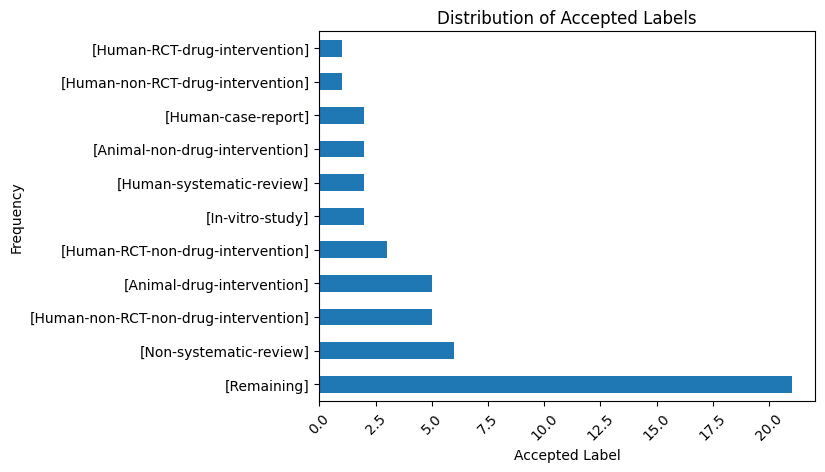

In [49]:
# Explode the 'accepted_label' column to have each label as a separate row
df_exploded = sampled_df.explode('accepted_label')

# Count the occurrences of each label
label_counts = sampled_df['accepted_label'].value_counts()

# Plot the distribution
label_counts.plot(kind='barh')
plt.title('Distribution of Accepted Labels')
plt.xlabel('Accepted Label')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [50]:
# Define a function to apply GPT queries with a progress bar
def apply_gpt_with_progress(data_series, task, prompt):
    results = []
    total_items = len(data_series)
    
    # Create a tqdm progress bar
    with tqdm(total=total_items, desc=f"Processing {task}") as pbar:
        for text in data_series:
            result = query_gpt(text, task, prompt)
            results.append(result)
            pbar.update(1)  # Update the progress bar

    return results

### run GPT

In [ ]:
sampled_df['gpt_predictions'] = apply_gpt_with_progress(sampled_df['abstract'], "classify", prompt)

Processing classify:   0%|                                                                                                                   | 0/50 [00:00<?, ?it/s]

Trying to call OpenAI API...


Processing classify:   2%|██▏                                                                                                        | 1/50 [00:20<16:59, 20.81s/it]

Trying to call OpenAI API...


Processing classify:   4%|████▎                                                                                                      | 2/50 [00:41<16:28, 20.59s/it]

Trying to call OpenAI API...


Processing classify:   6%|██████▍                                                                                                    | 3/50 [01:03<16:51, 21.52s/it]

Trying to call OpenAI API...


Processing classify:   8%|████████▌                                                                                                  | 4/50 [01:24<16:18, 21.28s/it]

Trying to call OpenAI API...


Processing classify:  10%|██████████▋                                                                                                | 5/50 [01:45<15:54, 21.22s/it]

Trying to call OpenAI API...


Processing classify:  12%|████████████▊                                                                                              | 6/50 [02:06<15:26, 21.05s/it]

Trying to call OpenAI API...


Processing classify:  14%|██████████████▉                                                                                            | 7/50 [02:27<15:01, 20.97s/it]

Trying to call OpenAI API...


Processing classify:  16%|█████████████████                                                                                          | 8/50 [02:48<14:38, 20.92s/it]

Trying to call OpenAI API...


Processing classify:  18%|███████████████████▎                                                                                       | 9/50 [03:08<14:12, 20.79s/it]

Trying to call OpenAI API...


Processing classify:  20%|█████████████████████▏                                                                                    | 10/50 [03:29<13:52, 20.81s/it]

Trying to call OpenAI API...


Processing classify:  22%|███████████████████████▎                                                                                  | 11/50 [03:50<13:37, 20.97s/it]

Trying to call OpenAI API...


Processing classify:  24%|█████████████████████████▍                                                                                | 12/50 [04:12<13:18, 21.01s/it]

Trying to call OpenAI API...


Processing classify:  26%|███████████████████████████▌                                                                              | 13/50 [04:33<12:58, 21.04s/it]

Trying to call OpenAI API...


Processing classify:  28%|█████████████████████████████▋                                                                            | 14/50 [04:53<12:33, 20.94s/it]

Trying to call OpenAI API...


Processing classify:  30%|███████████████████████████████▊                                                                          | 15/50 [05:15<12:17, 21.06s/it]

Trying to call OpenAI API...


Processing classify:  32%|█████████████████████████████████▉                                                                        | 16/50 [05:36<11:59, 21.18s/it]

Trying to call OpenAI API...


Processing classify:  34%|████████████████████████████████████                                                                      | 17/50 [06:03<12:32, 22.79s/it]

Trying to call OpenAI API...


Processing classify:  36%|██████████████████████████████████████▏                                                                   | 18/50 [06:24<11:52, 22.25s/it]

Trying to call OpenAI API...


Processing classify:  38%|████████████████████████████████████████▎                                                                 | 19/50 [06:46<11:27, 22.19s/it]

Trying to call OpenAI API...


Processing classify:  40%|██████████████████████████████████████████▍                                                               | 20/50 [07:06<10:52, 21.75s/it]

Trying to call OpenAI API...


Processing classify:  42%|████████████████████████████████████████████▌                                                             | 21/50 [07:27<10:22, 21.48s/it]

Trying to call OpenAI API...


Processing classify:  44%|██████████████████████████████████████████████▋                                                           | 22/50 [07:49<09:59, 21.42s/it]

Trying to call OpenAI API...


Processing classify:  46%|████████████████████████████████████████████████▊                                                         | 23/50 [08:10<09:39, 21.48s/it]

Trying to call OpenAI API...


Processing classify:  48%|██████████████████████████████████████████████████▉                                                       | 24/50 [08:31<09:13, 21.28s/it]

Trying to call OpenAI API...


Processing classify:  50%|█████████████████████████████████████████████████████                                                     | 25/50 [08:52<08:51, 21.25s/it]

Trying to call OpenAI API...


Processing classify:  52%|███████████████████████████████████████████████████████                                                   | 26/50 [09:13<08:28, 21.17s/it]

Trying to call OpenAI API...


Processing classify:  54%|█████████████████████████████████████████████████████████▏                                                | 27/50 [09:35<08:09, 21.29s/it]

Trying to call OpenAI API...


Processing classify:  56%|███████████████████████████████████████████████████████████▎                                              | 28/50 [09:55<07:44, 21.12s/it]

Trying to call OpenAI API...


Processing classify:  58%|█████████████████████████████████████████████████████████████▍                                            | 29/50 [10:16<07:22, 21.09s/it]

Trying to call OpenAI API...


Processing classify:  60%|███████████████████████████████████████████████████████████████▌                                          | 30/50 [10:38<07:01, 21.09s/it]

Trying to call OpenAI API...


Processing classify:  62%|█████████████████████████████████████████████████████████████████▋                                        | 31/50 [10:58<06:37, 20.92s/it]

Trying to call OpenAI API...


Processing classify:  64%|███████████████████████████████████████████████████████████████████▊                                      | 32/50 [11:19<06:16, 20.92s/it]

Trying to call OpenAI API...


Processing classify:  66%|█████████████████████████████████████████████████████████████████████▉                                    | 33/50 [11:40<05:57, 21.01s/it]

Trying to call OpenAI API...


Processing classify:  68%|████████████████████████████████████████████████████████████████████████                                  | 34/50 [12:01<05:36, 21.03s/it]

In [15]:
labels = ["Human-systematic-review", "Human-RCT-drug-intervention", "Human-RCT-non-drug-intervention", "Human-RCT-non-intervention", "Human-case-report", "Human-non-RCT-drug-intervention", "Human-non-RCT-non-drug-intervention", "Animal-systematic-review", "Animal-drug-intervention", "Animal-non-drug-intervention", "Animal-other", "Non-systematic-review", "In-vitro-study", "Clinical-study-protocol", "Remaining"]

label_to_numerical = {label: i for i, label in enumerate(labels)}
label_to_numerical["label missing"] = -1

In [16]:
label_to_numerical

{'Human-systematic-review': 0,
 'Human-RCT-drug-intervention': 1,
 'Human-RCT-non-drug-intervention': 2,
 'Human-RCT-non-intervention': 3,
 'Human-case-report': 4,
 'Human-non-RCT-drug-intervention': 5,
 'Human-non-RCT-non-drug-intervention': 6,
 'Animal-systematic-review': 7,
 'Animal-drug-intervention': 8,
 'Animal-non-drug-intervention': 9,
 'Animal-other': 10,
 'Non-systematic-review': 11,
 'In-vitro-study': 12,
 'Clinical-study-protocol': 13,
 'Remaining': 14,
 'label missing': -1}

In [17]:
df_exploded = sampled_df.explode('accepted_label')
df_exploded.head(3)

,pmid,journal_name,title,abstract,accepted_label,gpt_predictions
1109,23926278,"Journal of neurology, neurosurgery, and psychi...",Sera from patients with multifocal motor neuro...,"In multifocal motor neuropathy (MMN), the dest...",In-vitro-study,Human-case-report
370,31446316,NeuroImage. Clinical,White matter microstructural abnormalities in ...,This study assessed white matter microstructur...,Remaining,Human-non-RCT-non-drug-intervention
572,12472824,Journal of psychiatric and mental health nursing,Women's experiences of hospital admission.,The primary aim of this study was to examine w...,Remaining,Human-non-RCT-non-drug-intervention


### Evaluate performance

In [37]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import balanced_accuracy_score


In [19]:
# Adjust mapping to return -1 for labels not found in the map
df_exploded['accepted_label_numerical'] = df_exploded['accepted_label'].apply(lambda x: label_to_numerical.get(x, -1))
df_exploded['gpt_predictions_numerical'] = df_exploded['gpt_predictions'].apply(lambda x: label_to_numerical.get(x, -1))

In [23]:
len(labels)

15

In [39]:
# Extract arrays for evaluation
y_true = df_exploded['accepted_label_numerical'].values
y_pred = df_exploded['gpt_predictions_numerical'].values

# Evaluation
accuracy = accuracy_score(y_true, y_pred)
#report = classification_report(y_true, y_pred,output_dict=True, zero_division=0)
accuracy_balanced = balanced_accuracy_score(y_true, y_pred)

accuracy, accuracy_balanced # Note: proportion of correctly predicted observations to the total observations. It's most useful when the classes are balanced but can be misleading when dealing with imbalanced classes.

/Users/donevas/Library/Caches/pypoetry/virtualenvs/pubmed-abstract-classifier-wiYN7Q0G-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(0.24, 0.4242424242424242)

In [40]:
# Adjusting the classification report to only include relevant labels
unique_labels = sorted(set(y_true) | set(y_pred))
target_names_adjusted = [labels[i] for i in unique_labels]

# Recalculate classification report with adjusted target names
report_adjusted = classification_report(y_true, y_pred, output_dict=True, labels=unique_labels, target_names=target_names_adjusted, zero_division=0)


In [ ]:
# Convert the report to a DataFrame for visualization
report_df = pd.DataFrame(report_adjusted).transpose()

report_df

In [41]:
# note: The support is the number of occurrences of each class in y_true.
report_adjusted

{'Remaining': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 21.0},
 'Human-systematic-review': {'precision': 0.6666666666666666,
  'recall': 1.0,
  'f1-score': 0.8,
  'support': 2.0},
 'Human-RCT-drug-intervention': {'precision': 0.25,
  'recall': 1.0,
  'f1-score': 0.4,
  'support': 1.0},
 'Human-RCT-non-drug-intervention': {'precision': 0.5,
  'recall': 0.6666666666666666,
  'f1-score': 0.5714285714285714,
  'support': 3.0},
 'Human-case-report': {'precision': 0.14285714285714285,
  'recall': 1.0,
  'f1-score': 0.25,
  'support': 2.0},
 'Human-non-RCT-drug-intervention': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1.0},
 'Human-non-RCT-non-drug-intervention': {'precision': 0.15384615384615385,
  'recall': 0.4,
  'f1-score': 0.2222222222222222,
  'support': 5.0},
 'Animal-drug-intervention': {'precision': 0.75,
  'recall': 0.6,
  'f1-score': 0.6666666666666666,
  'support': 5.0},
 'Animal-non-drug-intervention': {'precision': 0.0,
  'recal

## Run the GPT task over the whole dataset

In [45]:
# gpt_predictions_conditions is the column
df['gpt_predictions'] = apply_gpt_with_progress(df['abstract'], "classify")

Processing classify: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.88s/it]


In [46]:
df

,pmid,journal_name,title,abstract,accepted_label,gpt_predictions
0,37550718,Trials,Can dexamethasone improve postoperative sleep ...,Perioperative sleep disorders (PSD) are an ind...,[Animal-other],Human-RCT-drug-intervention
1,2500373,Developmental medicine and child neurology,Effects of puberty on seizure frequency.,"Seizure frequency was documented before, durin...",[Remaining],Human-case-report
2,36189588,Journal of Alzheimer's disease : JAD,Characterization of Mild Cognitive Impairment ...,"Despite tremendous advancements in the field, ...",[Human-systematic-review],Human-case-report


In [47]:
ds_annotated_full_copy = df.copy()